# Speech Emotion Recognition With Convolutional Neural Network

# Content
1. [Including Libraries](#1)
2. [Including the Datasets](#2)
3. [Data Analyze](#3)
    * [Audio Augmentation](#7)
        * [Original Audio](#4)
        * [Noised Audio](#8)
        * [Streched Audio](#10)
        * [Shifted Audio](#11)
        * [Pitched Audio](#12)
    * [Feature Extraction](#13)
    * [Processing](#14)
4. [Including Analyzed Audio Features](#15)
5. [Processing Analyzed Data for Training](#16)
    * [Train, Test and Validation Spliting](#17)
    * [Tuning for Training](#18)
6. [Begin Training](#19)
7. [Drawing Charts](#20)
    * [Accuracy Charts](#21)
    * [Loss Charts](#22)
8. [Testing Model and Test Results](#24)
    * [Confusion Matrix](#25)

<a id="1"></a>
# Including Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import re
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="2"></a>
# Including the Datasets

In [2]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'
Ravdess_Path='../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24'
Savee_Path='../input/speech-emotion-recognition-en/Savee/'
Tess_Path='../input/speech-emotion-recognition-en/Tess/'
subesco_path = '/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO'

<a id="3"></a>
# Data Analyze

In [3]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

Emotion                                          File_Path
0  disgust  ../input/speech-emotion-recognition-en/Crema//...
1    happy  ../input/speech-emotion-recognition-en/Crema//...
2    happy  ../input/speech-emotion-recognition-en/Crema//...
3  disgust  ../input/speech-emotion-recognition-en/Crema//...
4  disgust  ../input/speech-emotion-recognition-en/Crema//...

In [4]:
Crema_df['Emotion'].unique()

array(['disgust', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

In [5]:
import os
import pandas as pd

# Initialize an empty list to store the file paths and emotions for SUBESCO
subesco = []

# Define the path to the SUBESCO dataset
SUBESCO_Path ='/kaggle/input/subescobangla-speech-emotion-dataset/SUBESCO'

# Iterate over each file in the SUBESCO directory
for wav in os.listdir(SUBESCO_Path):
    # Extract the emotion by splitting the filename
    parts = wav.partition(".wav")[0].split('_')
    
    # The emotion is located at index 4 according to the filename pattern provided
    emotion = parts[5]
    
    # Map the emotion codes to the corresponding emotion names
    if emotion == 'SAD':
        subesco.append(('sad', SUBESCO_Path + '/' + wav))
    elif emotion == 'ANGRY':
        subesco.append(('angry', SUBESCO_Path + '/' + wav))
    elif emotion == 'DISGUST':
        subesco.append(('disgust', SUBESCO_Path + '/' + wav))
    elif emotion == 'FEAR':
        subesco.append(('fear', SUBESCO_Path + '/' + wav))
    elif emotion == 'SURPRISE':
        subesco.append(('surprise', SUBESCO_Path + '/' + wav))
    elif emotion == 'HAPPY':
        subesco.append(('happy', SUBESCO_Path + '/' + wav))
    elif emotion == 'NEUTRAL':
        subesco.append(('neutral', SUBESCO_Path + '/' + wav))
    else:
        subesco.append(('unknown', SUBESCO_Path + '/' + wav))

# Convert the list to a DataFrame
Subesco_df = pd.DataFrame.from_records(subesco, columns=['Emotion', 'File_Path'])

# Display the first few rows of the DataFrame
Subesco_df.head()


Emotion                                          File_Path
0      fear  /kaggle/input/subescobangla-speech-emotion-dat...
1      fear  /kaggle/input/subescobangla-speech-emotion-dat...
2  surprise  /kaggle/input/subescobangla-speech-emotion-dat...
3     angry  /kaggle/input/subescobangla-speech-emotion-dat...
4     angry  /kaggle/input/subescobangla-speech-emotion-dat...

In [6]:
Subesco_df['Emotion'].unique()

array(['fear', 'surprise', 'angry', 'neutral', 'sad', 'disgust', 'happy'],
      dtype=object)

In [7]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

Emotion                                          File_Path
0  surprise  ../input/speech-emotion-recognition-en/Ravdess...
1   neutral  ../input/speech-emotion-recognition-en/Ravdess...
2   disgust  ../input/speech-emotion-recognition-en/Ravdess...
3   disgust  ../input/speech-emotion-recognition-en/Ravdess...
4   neutral  ../input/speech-emotion-recognition-en/Ravdess...

In [8]:
Ravdess_df['Emotion'].unique()

array(['surprise', 'neutral', 'disgust', 'fear', 'sad', 'happy', 'angry'],
      dtype=object)

In [9]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

Emotion                                          File_Path
0    happy  ../input/speech-emotion-recognition-en/Savee//...
1     fear  ../input/speech-emotion-recognition-en/Savee//...
2    happy  ../input/speech-emotion-recognition-en/Savee//...
3  disgust  ../input/speech-emotion-recognition-en/Savee//...
4    angry  ../input/speech-emotion-recognition-en/Savee//...

In [10]:
Savee_df['Emotion'].unique()

array(['happy', 'fear', 'disgust', 'angry', 'surprise', 'neutral', 'sad'],
      dtype=object)

In [11]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

Emotion                                          File_Path
0    fear  ../input/speech-emotion-recognition-en/Tess/YA...
1    fear  ../input/speech-emotion-recognition-en/Tess/YA...
2    fear  ../input/speech-emotion-recognition-en/Tess/YA...
3    fear  ../input/speech-emotion-recognition-en/Tess/YA...
4    fear  ../input/speech-emotion-recognition-en/Tess/YA...

In [12]:
Tess_df['Emotion'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprise', 'happy'],
      dtype=object)

In [13]:
main_df=main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df,Subesco_df],axis=0)
main_df.shape

(19162, 2)

In [14]:
main_df.head(15)

Emotion                                          File_Path
0   disgust  ../input/speech-emotion-recognition-en/Crema//...
1     happy  ../input/speech-emotion-recognition-en/Crema//...
2     happy  ../input/speech-emotion-recognition-en/Crema//...
3   disgust  ../input/speech-emotion-recognition-en/Crema//...
4   disgust  ../input/speech-emotion-recognition-en/Crema//...
5   disgust  ../input/speech-emotion-recognition-en/Crema//...
6     happy  ../input/speech-emotion-recognition-en/Crema//...
7       sad  ../input/speech-emotion-recognition-en/Crema//...
8   disgust  ../input/speech-emotion-recognition-en/Crema//...
9       sad  ../input/speech-emotion-recognition-en/Crema//...
10    happy  ../input/speech-emotion-recognition-en/Crema//...
11  neutral  ../input/speech-emotion-recognition-en/Crema//...
12     fear  ../input/speech-emotion-recognition-en/Crema//...
13    happy  ../input/speech-emotion-recognition-en/Crema//...
14     fear  ../input/speech-emotion-recognition-en/Crema//...

In [15]:
main_df.tail(15)

Emotion                                          File_Path
6985     angry  /kaggle/input/subescobangla-speech-emotion-dat...
6986       sad  /kaggle/input/subescobangla-speech-emotion-dat...
6987       sad  /kaggle/input/subescobangla-speech-emotion-dat...
6988   disgust  /kaggle/input/subescobangla-speech-emotion-dat...
6989  surprise  /kaggle/input/subescobangla-speech-emotion-dat...
6990   neutral  /kaggle/input/subescobangla-speech-emotion-dat...
6991       sad  /kaggle/input/subescobangla-speech-emotion-dat...
6992     happy  /kaggle/input/subescobangla-speech-emotion-dat...
6993   neutral  /kaggle/input/subescobangla-speech-emotion-dat...
6994       sad  /kaggle/input/subescobangla-speech-emotion-dat...
6995     happy  /kaggle/input/subescobangla-speech-emotion-dat...
6996     happy  /kaggle/input/subescobangla-speech-emotion-dat...
6997       sad  /kaggle/input/subescobangla-speech-emotion-dat...
6998     angry  /kaggle/input/subescobangla-speech-emotion-dat...
6999  surprise  /kaggle/input/subescobangla-speech-emotion-dat...

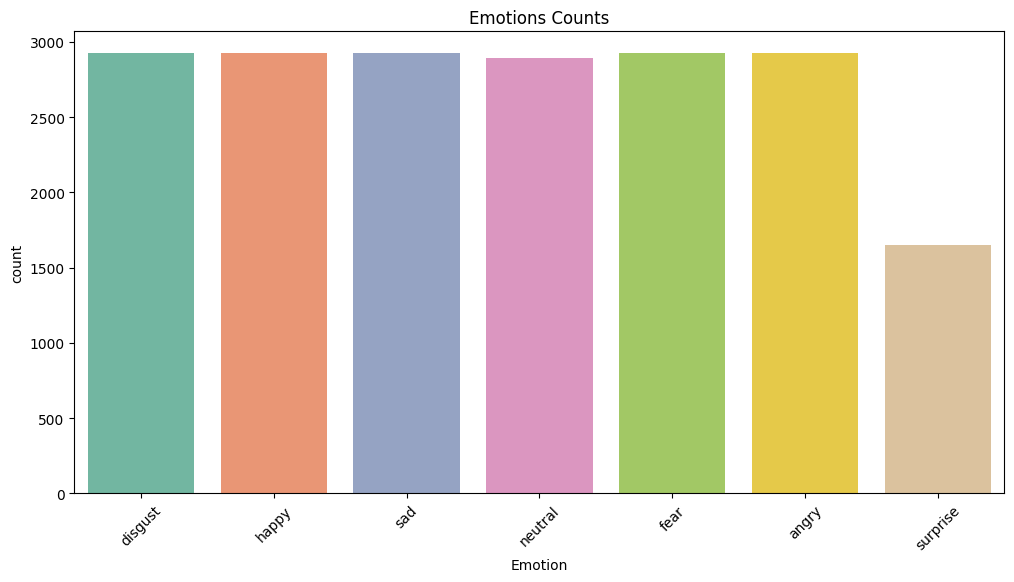

In [16]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

In [17]:
emotion_names=main_df['Emotion'].unique()

In [18]:
colors={'disgust':'#804E2D','happy':'#F19C0E','sad':'#478FB8','neutral':'#4CB847','fear':'#7D55AA','angry':'#C00808','surprise':'#EE00FF'}

In [19]:
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr,color=color)

In [20]:
def spectogram(data,sr,emotion):
    audio=librosa.stft(data)
    audio_db=librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for spectogram',size=17)
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

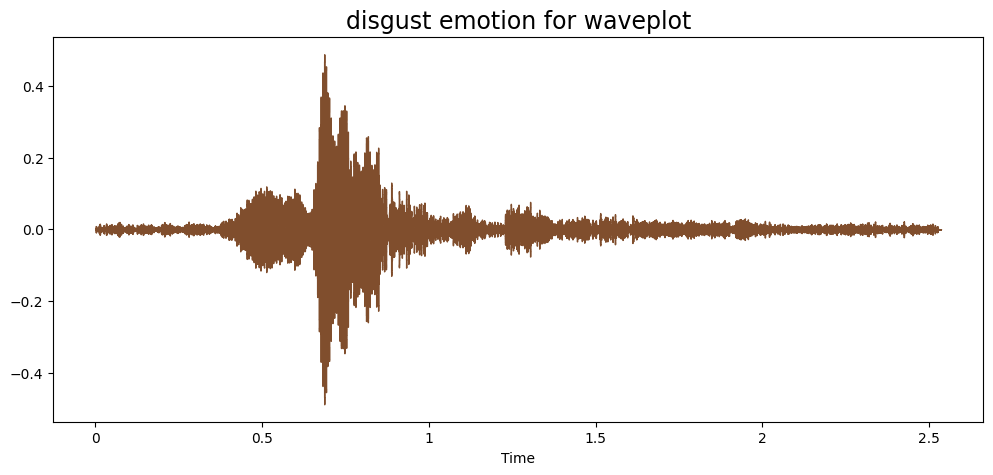

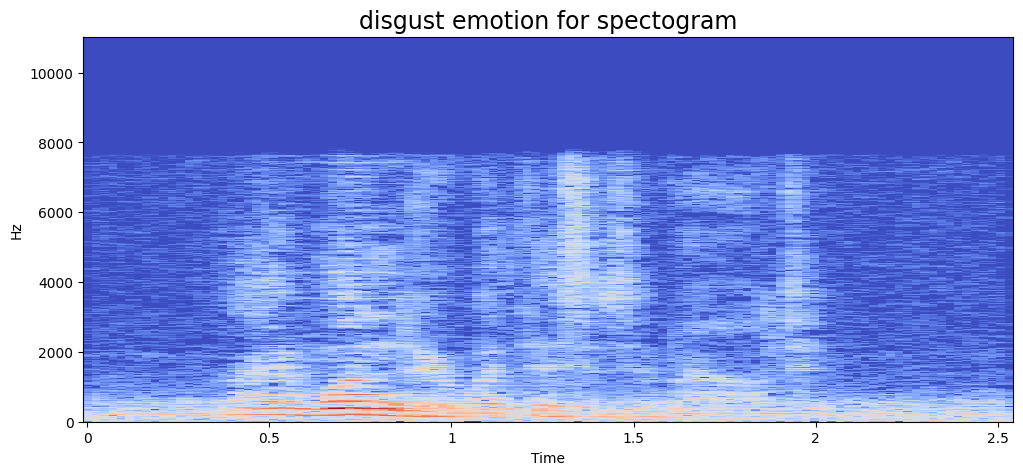

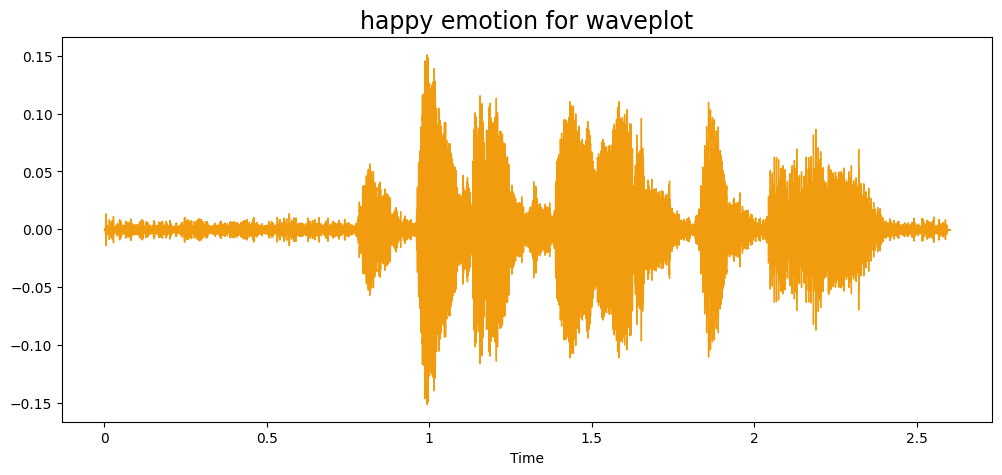

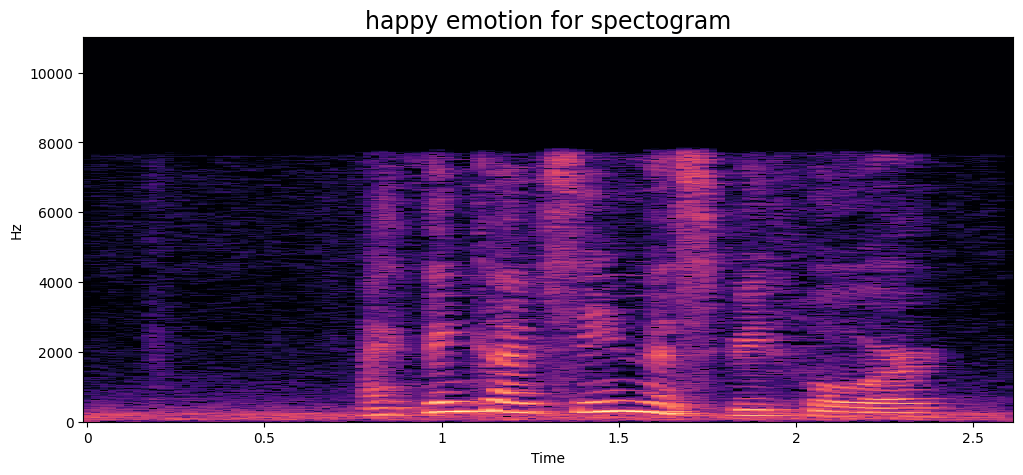

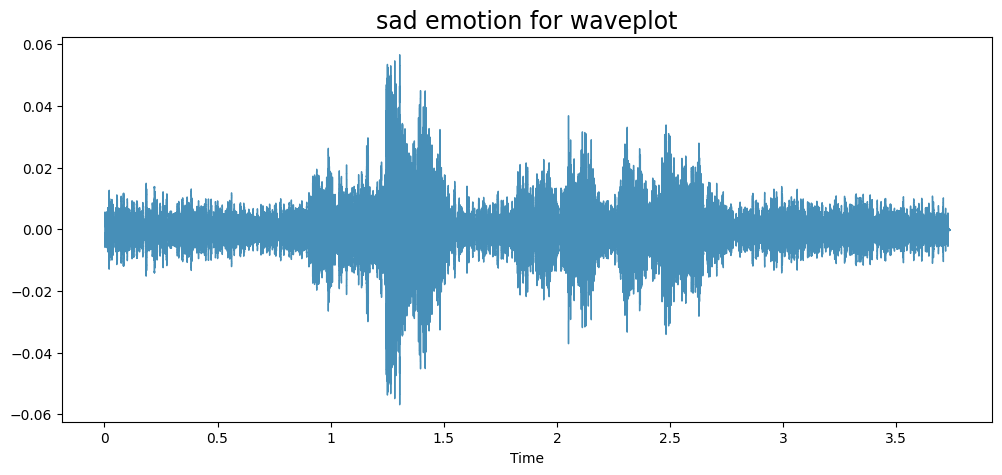

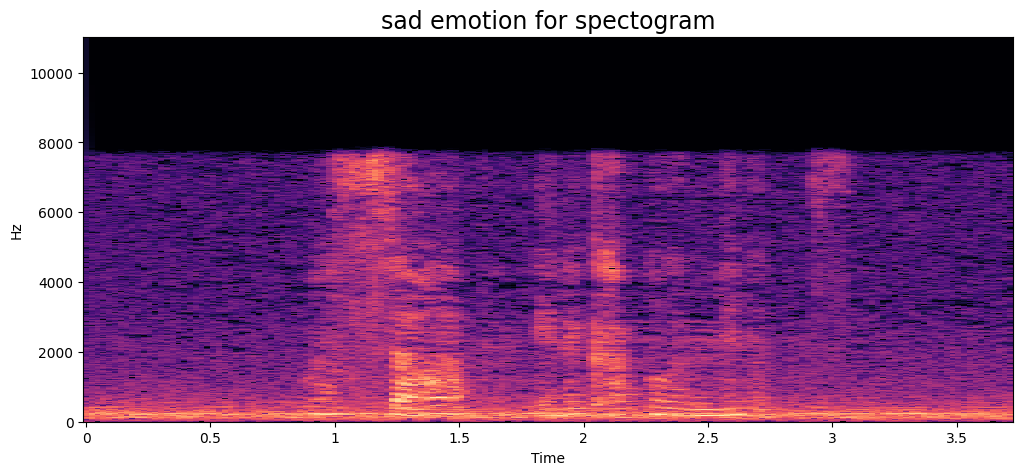

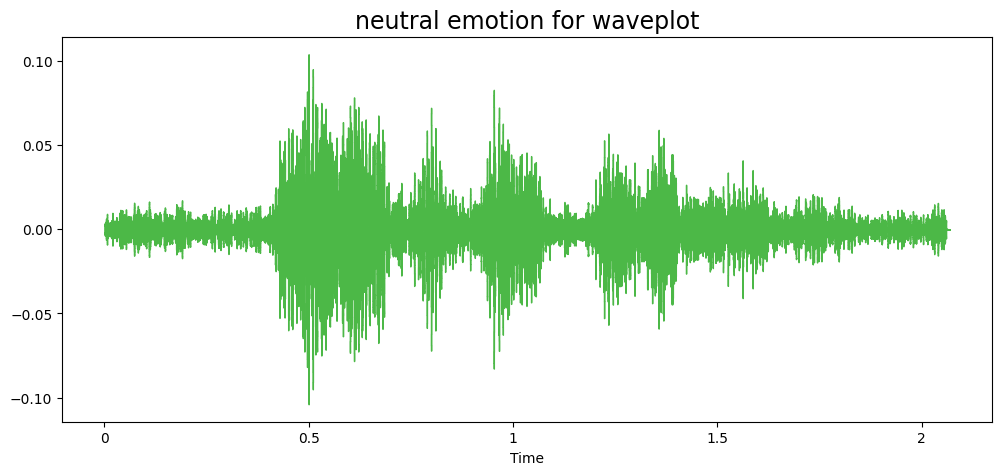

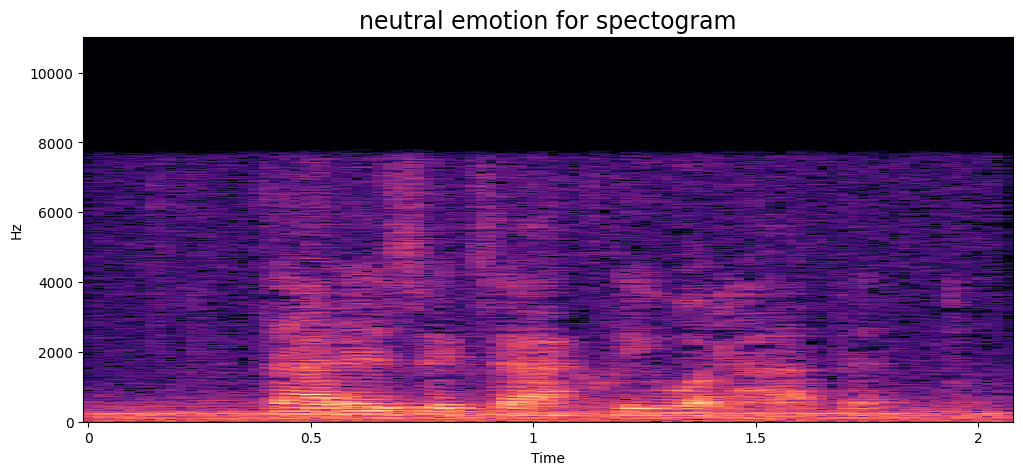

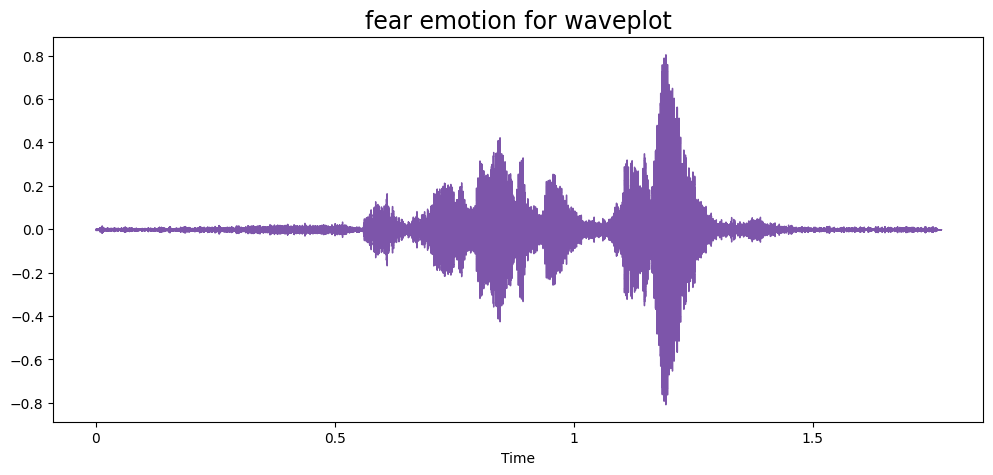

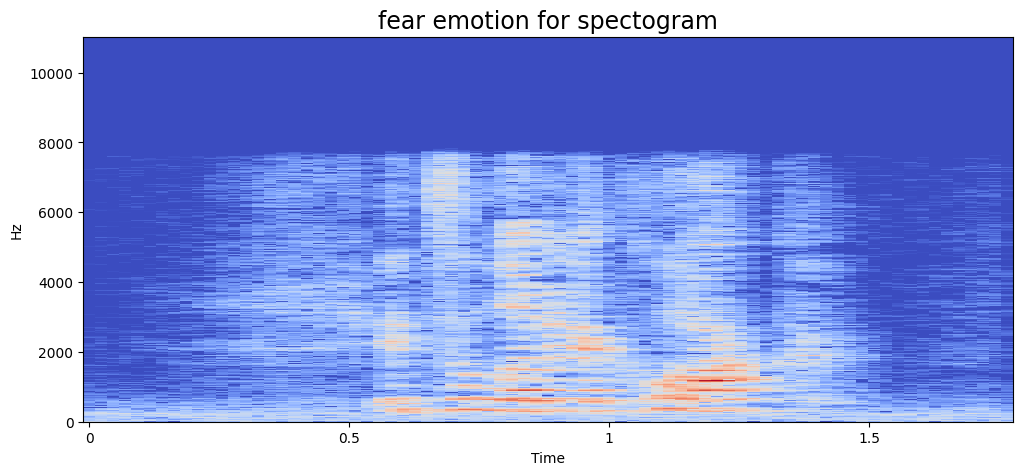

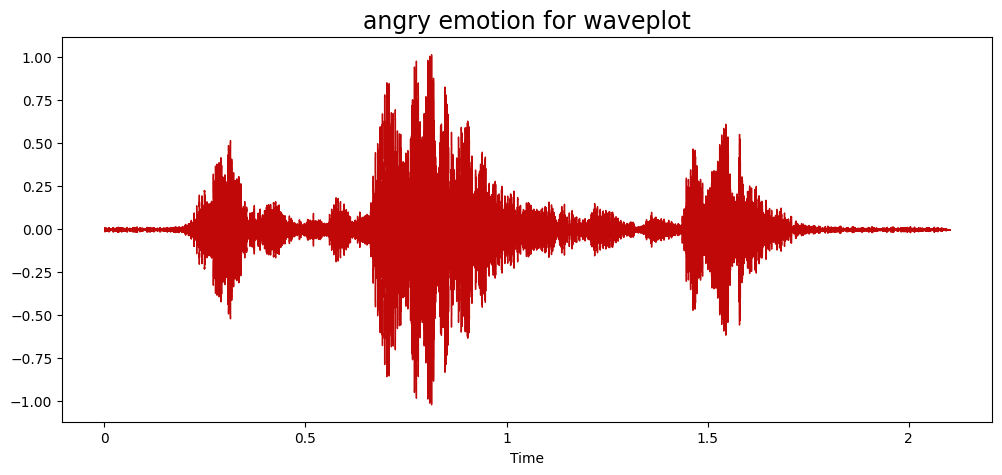

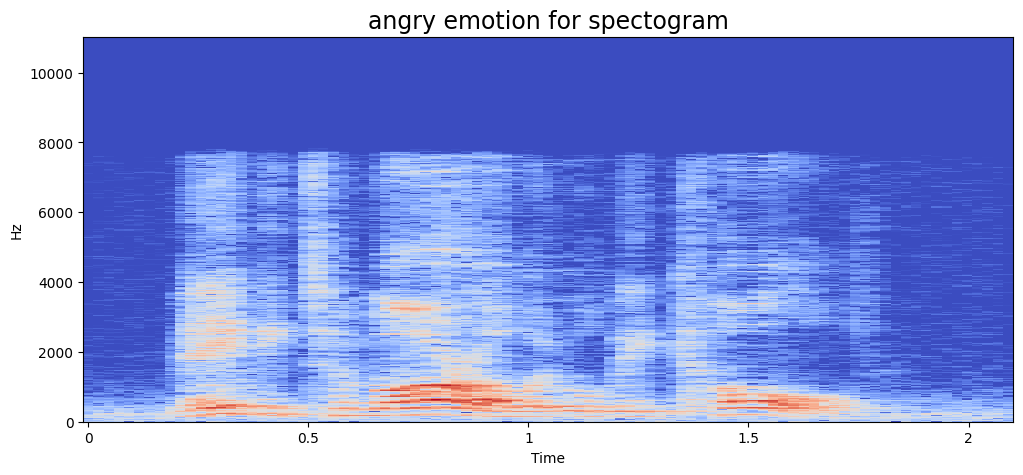

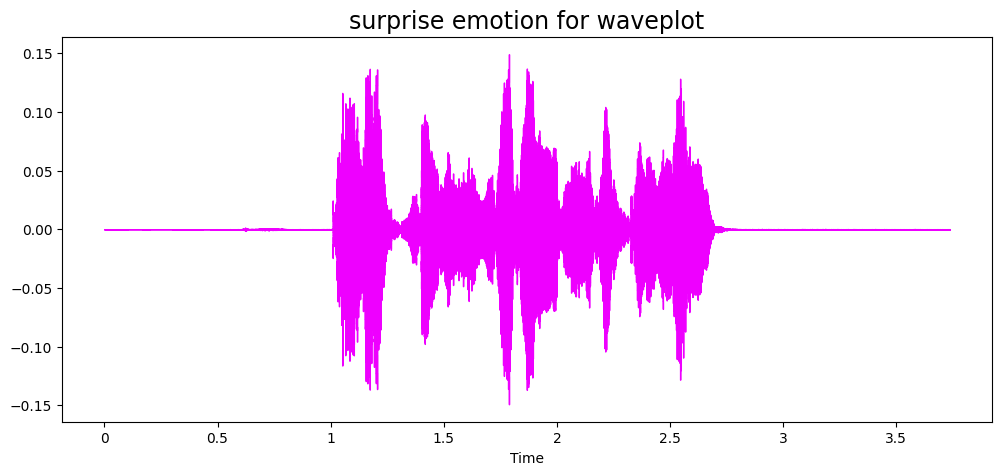

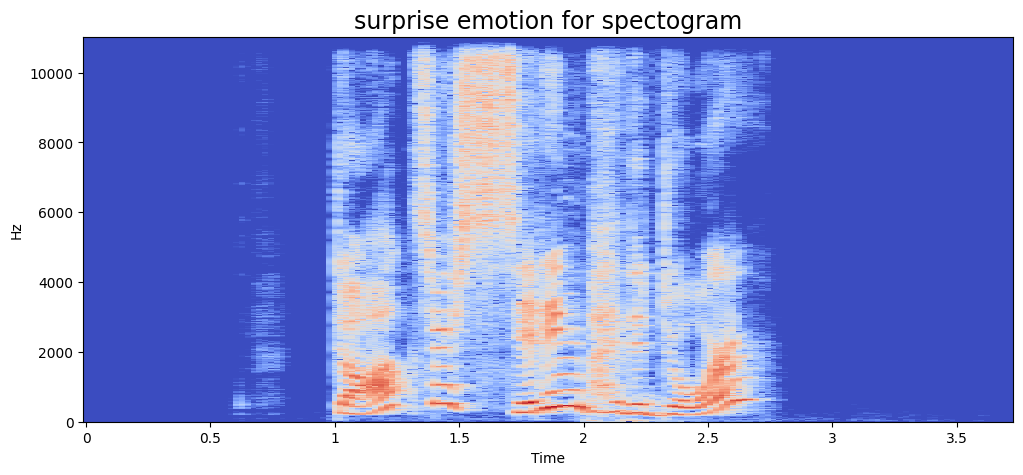

In [21]:
audio_path=[]
for emotion in emotion_names:
    path=np.array(main_df['File_Path'][main_df['Emotion']==emotion])[1]
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,colors[emotion])
    spectogram(data,sr,emotion)
    audio_path.append(path)

In [22]:
print('Disgust Audio Sample\n')
IPython.display.Audio(audio_path[0])

Disgust Audio Sample



In [23]:
print('Happy Audio Sample\n')
IPython.display.Audio(audio_path[1])

Happy Audio Sample



In [24]:
print('Sad Audio Sample\n')
IPython.display.Audio(audio_path[2])

Sad Audio Sample



In [25]:
print('Neutral Audio Sample\n')
IPython.display.Audio(audio_path[3])

Neutral Audio Sample



In [26]:
print('Fear Audio Sample\n')
IPython.display.Audio(audio_path[4])

Fear Audio Sample



In [27]:
print('Angry Audio Sample\n')
IPython.display.Audio(audio_path[5])

Angry Audio Sample



In [28]:
print('Surprise Audio Sample\n')
IPython.display.Audio(audio_path[6])

Surprise Audio Sample



<a id="7"></a>
## Audio Augmentation

In [29]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps = pitch_factor)

def streching(data,rate=0.8):
    return librosa.effects.time_stretch(y = data,rate= rate)
    
    

In [30]:
data,sr=librosa.load(audio_path[6])

<a id="4"></a>
### Orijinal Audio

<Figure size 1200x500 with 0 Axes>

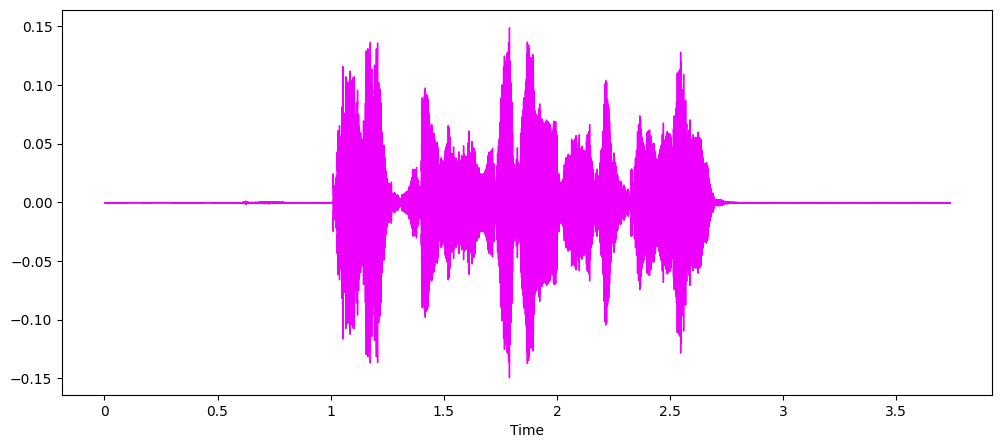

In [31]:
plt.figure(figsize=(12,5))
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
librosa.display.waveshow(y=data, sr=sr, color='#EE00FF')

IPython.display.Audio(audio_path[6])

<a id="8"></a>
### Noised Audio

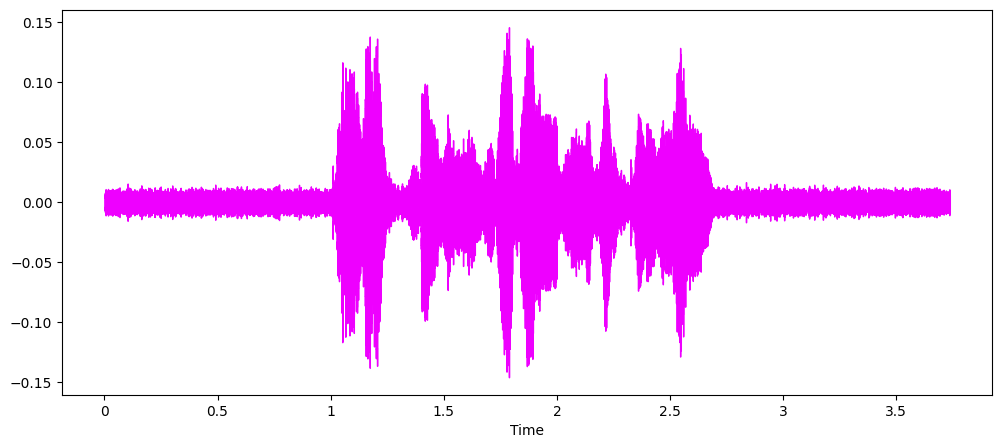

In [32]:
noised_audio=add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=noised_audio,sr=sr,color='#EE00FF')
IPython.display.Audio(noised_audio,rate=sr)

<a id="10"></a>
### Streched Audio

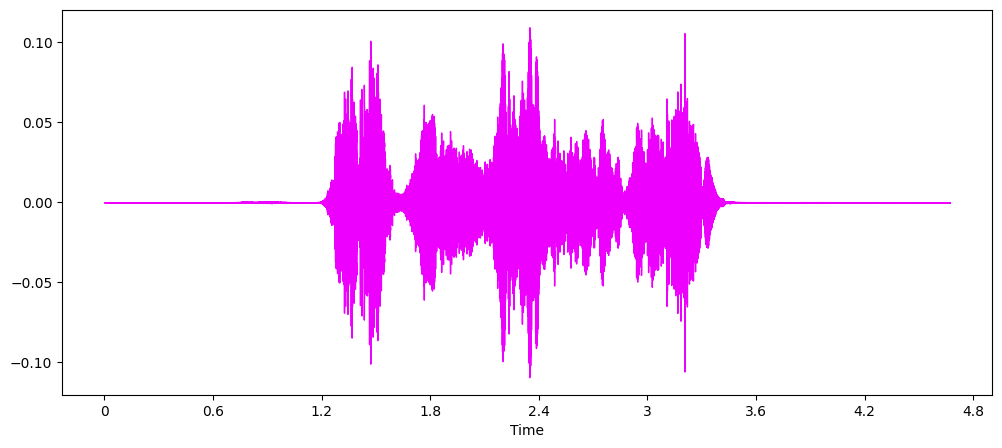

In [33]:
stretched_audio=streching(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = stretched_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(stretched_audio,rate=sr)

<a id="11"></a>
### Shifted Audio

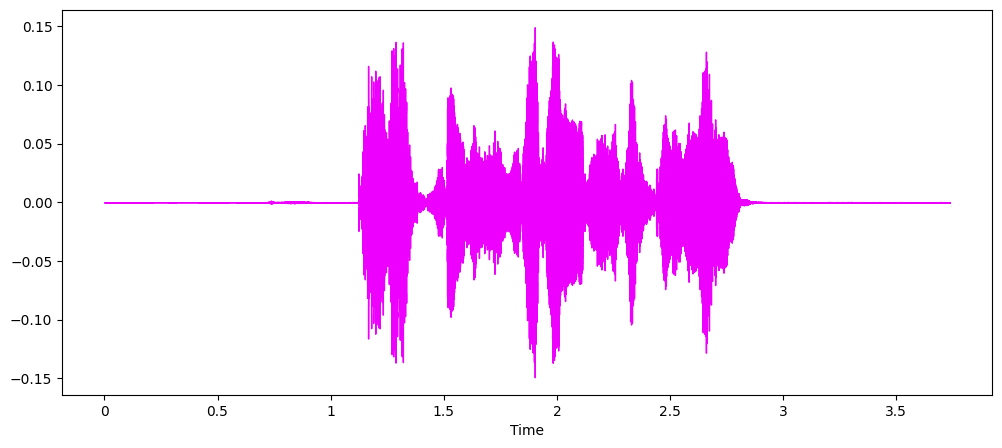

In [34]:
shifted_audio=shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = shifted_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(shifted_audio,rate=sr)

<a id="12"></a>
### Pitched Audio

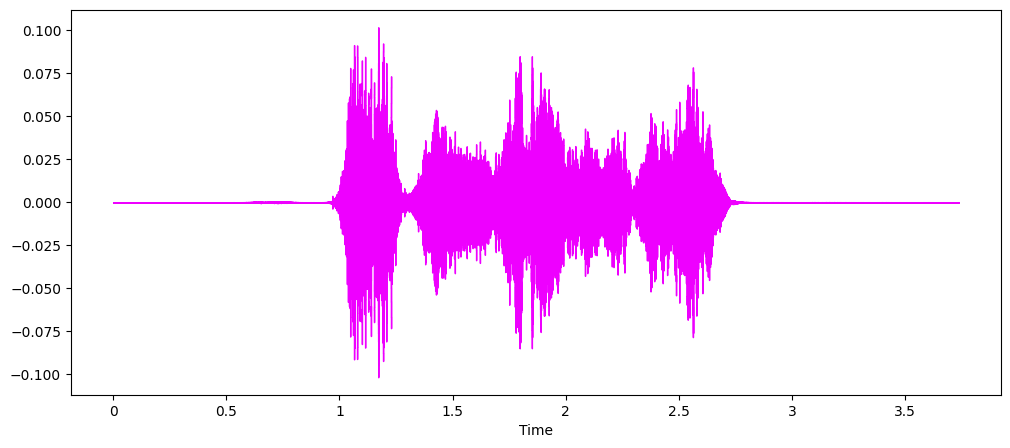

In [35]:
pitched_audio=pitching(data,sr)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y = pitched_audio,sr = sr,color='#EE00FF')
IPython.display.Audio(pitched_audio,rate=sr)

<a id="13"></a>
## Feature Extraction

In [36]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      #zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      #mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)
    
    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitching(data,sr,random=True)
    pitched_noised_audio=add_noise(pitched_audio1,random=True)
    aud4=extract_features(pitched_noised_audio,sr)
    audio=np.vstack((audio,aud4))
    
    return audio
def rmse(data, frame_length=2048, hop_length=512):
    # Specify 'y' as the keyword for data
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


<a id="14"></a>
## Processing

In [37]:
X,Y=[],[]
for path,emotion,index in zip(main_df.File_Path,main_df.Emotion,range(main_df.File_Path.shape[0])):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')

0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2000 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
7500 audio has been processed
8000 audio has been processed
8500 audio has been processed
9000 audio has been processed
9500 audio has been processed
10000 audio has been processed
10500 audio has been processed
11000 audio has been processed
11500 audio has been processed
12000 audio has been processed
12500 audio has been processed
13000 audio has been processed
13500 audio has been processed
14000 audio has been processed
14500 audio has been processed
15000 audio has been processed
15500 audio has been processed
16000 audio has been processed
1

In [38]:
processed_data_path='./processed_data.csv'

In [39]:
extract=pd.DataFrame(X)
extract['Emotion']=Y
extract.to_csv(processed_data_path,index=False)
extract.head(10)

0         1         2         3         4         5         6  \
0  0.007247  0.008623  0.010180  0.009761  0.009103  0.008572  0.007390   
1  0.007249  0.008624  0.010180  0.009762  0.009102  0.008570  0.007388   
2  0.007365  0.008484  0.009364  0.008205  0.007117  0.006324  0.006438   
3  0.007367  0.008457  0.009376  0.008258  0.007089  0.006388  0.006315   
4  0.017618  0.021621  0.023024  0.021174  0.016389  0.011086  0.009629   
5  0.017618  0.021621  0.023024  0.021174  0.016389  0.011086  0.009629   
6  0.017863  0.021345  0.022562  0.020487  0.015001  0.009933  0.008021   
7  0.017850  0.021355  0.022574  0.020484  0.015034  0.009934  0.008006   
8  0.002489  0.003131  0.003711  0.003762  0.003639  0.003411  0.003975   
9  0.004400  0.005293  0.006213  0.006207  0.006089  0.005914  0.006173   

          7         8         9  ...  99  100  101  102  103  104  105  106  \
0  0.012164  0.016958  0.020769  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.012160  0.016957  0.020767  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  0.010944  0.014554  0.018164  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  0.011257  0.014412  0.017960  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  0.010510  0.011910  0.014293  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5  0.010510  0.011910  0.014293  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
6  0.008332  0.009553  0.011692  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
7  0.008298  0.009603  0.011705  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
8  0.008441  0.013243  0.015541  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
9  0.009711  0.014037  0.016278  ... NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   107  Emotion  
0  NaN  disgust  
1  NaN  disgust  
2  NaN  disgust  
3  NaN  disgust  
4  NaN    happy  
5  NaN    happy  
6  NaN    happy  
7  NaN    happy  
8  NaN    happy  
9  NaN    happy  

[10 rows x 109 columns]

<a id="15"></a>
# Including Analyzed Audio Features

In [40]:
df=pd.read_csv(processed_data_path)
df.shape

(76648, 109)

In [41]:
df=df.fillna(0)
print(df.isna().any())
df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
104        False
105        False
106        False
107        False
Emotion    False
Length: 109, dtype: bool


(76648, 109)

In [42]:
df.head(10)

0         1         2         3         4         5         6  \
0  0.007247  0.008623  0.010180  0.009761  0.009103  0.008572  0.007390   
1  0.007249  0.008624  0.010180  0.009762  0.009102  0.008570  0.007388   
2  0.007365  0.008484  0.009364  0.008205  0.007117  0.006324  0.006438   
3  0.007367  0.008457  0.009376  0.008258  0.007089  0.006388  0.006315   
4  0.017618  0.021621  0.023024  0.021174  0.016389  0.011086  0.009629   
5  0.017618  0.021621  0.023024  0.021174  0.016389  0.011086  0.009629   
6  0.017863  0.021345  0.022562  0.020487  0.015001  0.009933  0.008021   
7  0.017850  0.021355  0.022574  0.020484  0.015034  0.009934  0.008006   
8  0.002489  0.003131  0.003711  0.003762  0.003639  0.003411  0.003975   
9  0.004400  0.005293  0.006213  0.006207  0.006089  0.005914  0.006173   

          7         8         9  ...   99  100  101  102  103  104  105  106  \
0  0.012164  0.016958  0.020769  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.012160  0.016957  0.020767  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.010944  0.014554  0.018164  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.011257  0.014412  0.017960  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.010510  0.011910  0.014293  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5  0.010510  0.011910  0.014293  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6  0.008332  0.009553  0.011692  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7  0.008298  0.009603  0.011705  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8  0.008441  0.013243  0.015541  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9  0.009711  0.014037  0.016278  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   107  Emotion  
0  0.0  disgust  
1  0.0  disgust  
2  0.0  disgust  
3  0.0  disgust  
4  0.0    happy  
5  0.0    happy  
6  0.0    happy  
7  0.0    happy  
8  0.0    happy  
9  0.0    happy  

[10 rows x 109 columns]

<a id="16"></a>
# Processing Analyzed Data for Training

In [43]:
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']

In [44]:
lb=LabelEncoder()
#Y=np_utils.to_categorical(lb.fit_transform(Y))
Y=to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

<a id="17"></a>
## Train, Test and Validation Spliting

In [45]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((61318, 108), (15330, 108), (61318, 7), (15330, 7))

In [46]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

((55186, 108), (15330, 108), (6132, 108), (55186, 7), (15330, 7), (6132, 7))

In [47]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((55186, 108), (15330, 108), (6132, 108), (55186, 7), (15330, 7), (6132, 7))

In [48]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((55186, 108, 1), (15330, 108, 1), (6132, 108, 1))

<a id="18"></a>
## Tuning for Training

In [49]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [50]:
EPOCH=100
BATCH_SIZE=64

<a id="19"></a>
# Begin Training

In [51]:
mode1l=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

In [52]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

# Define the CNN part
cnn_input = tf.keras.Input(shape=(X_train.shape[1], 1))
x = L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(cnn_input)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=5, strides=2, padding='same')(x)
x = L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
cnn_output = L.MaxPool1D(pool_size=3, strides=2, padding='same')(x)

# Flatten CNN output for concatenation later
cnn_output_flattened = L.Flatten()(cnn_output)

# Define the Transformer Encoder part
# Input shape matches CNN output for concatenation purposes
transformer_input = L.Reshape((-1, 128))(cnn_output)  # Reshape CNN output to match transformer input
transformer_encoder = L.MultiHeadAttention(num_heads=8, key_dim=128)(transformer_input, transformer_input)
transformer_encoder = L.LayerNormalization()(transformer_encoder)
transformer_output = L.Flatten()(transformer_encoder)  # Flatten for concatenation

# Concatenate CNN and Transformer outputs
concatenated = L.Concatenate()([cnn_output_flattened, transformer_output])

# Dense Layers
x = L.Dense(512, activation='relu')(concatenated)
x = L.BatchNormalization()(x)
output = L.Dense(7, activation='softmax')(x)

# Define and compile the model
model = Model(inputs=cnn_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 108, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 108, 512)  │      3,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 108, 512)  │      2,048 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 54, 512)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 54, 512)   │  1,311,232 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 512)   │      2,048 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 27, 512)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 27, 256)   │    655,616 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 27, 256)   │      1,024 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 14, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 14, 256)   │    196,864 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 256)   │      1,024 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 7, 256)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 7, 128)    │     98,432 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 128)    │        512 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 4, 128)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 128)    │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 128)    │    527,488 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 4, 128)    │        256 │ multi_head_atten

 Total params: 3,330,055 (12.70 MB)

 Trainable params: 3,325,703 (12.69 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [53]:
#history=model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE)

In [54]:
#from tensorflow.keras.models import load_model

# Load the model
#model = load_model('/kaggle/working/res_model.h5')


In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks with appropriate mode
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, callbacks=[early_stop, lr_reduction])


Epoch 1/50


I0000 00:00:1731158345.187442     110 service.cc:145] XLA service 0x5a855baa9de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731158345.187526     110 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 16/863 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.1873 - loss: 2.6223  

I0000 00:00:1731158350.557791     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


863/863 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.3251 - loss: 1.7606 - val_accuracy: 0.3387 - val_loss: 1.7726 - learning_rate: 0.0010
Epoch 2/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4397 - loss: 1.4501 - val_accuracy: 0.3888 - val_loss: 1.6188 - learning_rate: 0.0010
Epoch 3/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.4873 - loss: 1.3285 - val_accuracy: 0.3708 - val_loss: 1.6716 - learning_rate: 0.0010
Epoch 4/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5194 - loss: 1.2461 - val_accuracy: 0.5205 - val_loss: 1.2588 - learning_rate: 0.0010
Epoch 5/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5643 - loss: 1.1437 - val_accuracy: 0.5011 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 6/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5979 - loss: 1.0626 - val_accuracy: 0.4493 - val_loss: 1.5125 - learning_rate: 0.0010
Epoch 7/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6453 - loss: 0.9398 - val

<a id="20"></a>
# Drawing Charts

<a id="21"></a>
## Accuracy Charts

<a id="22"></a>
## Loss Charts

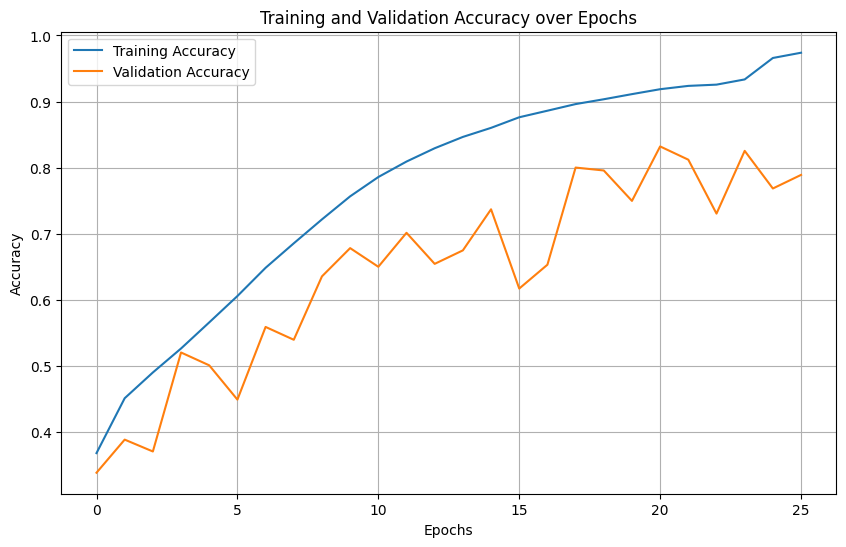

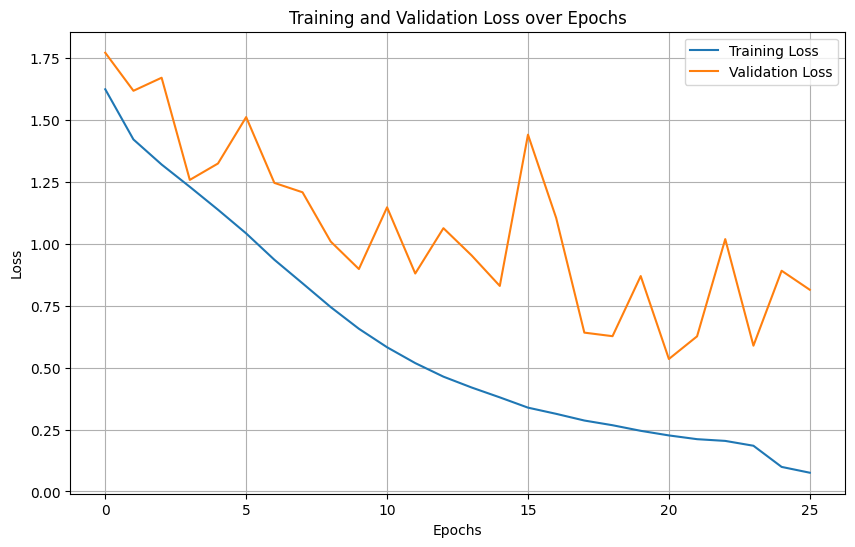

In [56]:
import matplotlib.pyplot as plt

# Plot Accuracy Curve
fig_accuracy = plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Curve
fig_loss = plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


<a id="24"></a>
# Testing Model and Test Results

In [57]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


array([0, 2, 6, ..., 5, 6, 6])

In [58]:
y_check=np.argmax(y_test,axis=1)
y_check

array([0, 0, 6, ..., 5, 6, 6])

In [59]:
loss,accuracy=model.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.582760214805603
Test Accuracy: 0.8235486149787903


<a id="25"></a>
## Confusion Matrix

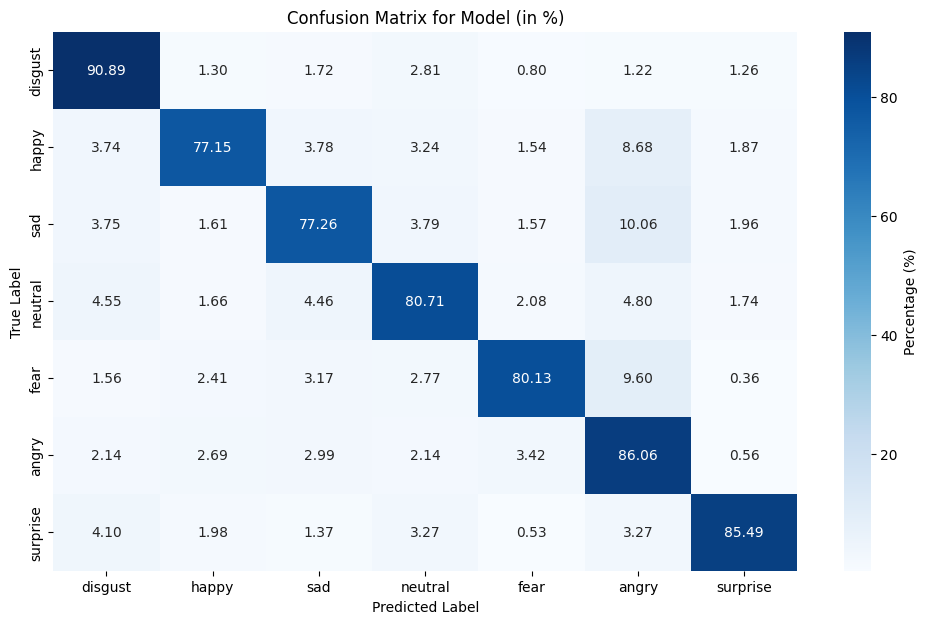

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf = confusion_matrix(y_check, y_pred)

# Normalize the confusion matrix to get percentages
conf_percent = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis] * 100

# Convert the confusion matrix to a DataFrame with labeled rows and columns
cm = pd.DataFrame(
    conf_percent, 
    index=[i for i in emotion_names], 
    columns=[i for i in emotion_names]
)

# Plot the confusion matrix with percentages
plt.figure(figsize=(12, 7))
ax = sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Percentage (%)'})
ax.set_title('Confusion Matrix for Model (in %)')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()


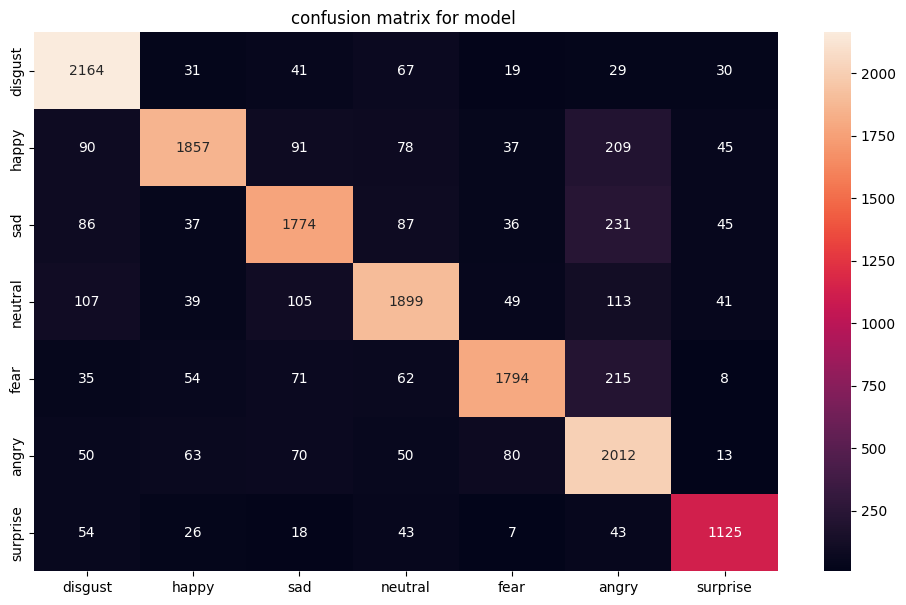

In [61]:
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

In [62]:
print(f'Model Confusion Matrix\n',classification_report(y_check,y_pred,target_names=emotion_names))

Model Confusion Matrix
               precision    recall  f1-score   support

     disgust       0.84      0.91      0.87      2381
       happy       0.88      0.77      0.82      2407
         sad       0.82      0.77      0.79      2296
     neutral       0.83      0.81      0.82      2353
        fear       0.89      0.80      0.84      2239
       angry       0.71      0.86      0.78      2338
    surprise       0.86      0.85      0.86      1316

    accuracy                           0.82     15330
   macro avg       0.83      0.83      0.83     15330
weighted avg       0.83      0.82      0.82     15330



In [63]:
model_path = "./res_model.h5"

model.save(model_path)

In [64]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df,Subesco_df],axis=0)